Train with brain uniaxial tension data. 

In [1]:
import jax.numpy as np
import numpy as onp
import matplotlib.pyplot as plt
import matplotlib
font = {'size'   : 14}
matplotlib.rc('font', **font)
from jax import grad, random, jit, vmap
from functools import partial
import jax.example_libraries.optimizers as optimizers
import pickle
key = random.PRNGKey(0)
import pandas as pd

from utils import uniaxial_relax, sigma_split_vmap, sigma_neoHook_vmap, init_params_nobias, init_params_positivebias, dPhi_RG_vmap, dPhi_vmap, plot45, uniaxial_monotone
from utils import uniaxial_cyclic

In [2]:
# Functions for training
@partial(jit, static_argnums=(0,1,2,))
def step(loss_fn, norm, useNODE, i, opt_state, inp_batch, out_batch):
    params = get_params(opt_state)
    g = grad(loss_fn, argnums=0)(params, norm, useNODE, inp_batch, out_batch)
    return opt_update(i, g, opt_state)

def train(inp, out, norm, useNODE, opt_state, key, loss_fn, nIter = 1000, batch_size=10, print_freq=100):
    train_loss = []
    val_loss = []
    for it in range(nIter+1):
        key, subkey = random.split(key)
        i = random.choice(subkey, inp.shape[0], shape=(batch_size,), replace = False)
        i = tuple([i])
        opt_state = step(loss_fn, norm, useNODE, it, opt_state, inp[i], out[i])
        if it % print_freq == 0 or it == nIter:
            params = get_params(opt_state)
            train_loss_value = loss_fn(params, norm, useNODE, inp, out)
            train_loss.append(train_loss_value)
            to_print = "it %i, train loss = %e" % (it, train_loss_value)
            print(to_print)
    return get_params(opt_state), train_loss, val_loss 

def uniaxial_cyclic_loss(params, norm, useNODE, inp, out):
    lm1peak = 1.1
    sigma_pr,_,_,_,_,_,_ = uniaxial_cyclic(params, norm, useNODE, inp[0], inp[1], lm1peak, dt0=0.5)
    loss = np.mean((sigma_pr[:,0,0]-out)**2)# + (sigma_pr[:,1,1]-out[1])**2)
    return loss
uniaxial_cyclic_loss_vmap = vmap(uniaxial_cyclic_loss, in_axes=(None, None, None, 0, 0), out_axes=0)
uniaxial_cyclic_batch_loss = lambda params, norm, useNODE, inp, out: np.mean(uniaxial_cyclic_loss_vmap(params, norm, useNODE, inp, out))

def Psi_loss(params, norm, useNODE, lmb, sigma_gt):
    lm1 = lmb[:,0]
    lm2 = lmb[:,1]
    lm3 = lmb[:,2]
    sigma_pr = sigma_split_vmap(lm1, lm2, lm3, params)
    loss1 = np.average((sigma_pr[:,0,0]-sigma_gt[:,0,0])**2) 
    loss2 = np.average((sigma_pr[:,1,1]-sigma_gt[:,1,1])**2)
    loss3 = np.average((sigma_pr[:,2,2]-sigma_gt[:,2,2])**2)
    loss = (loss1+loss2+loss3)/3
    return  loss

def Phi_loss(params, norm, useNODE, taui, dphidtaui_gt):
    tau1, tau2, tau3 = taui.transpose()
    dphidtaui_pr = dPhi_vmap([tau1, tau2, tau3], params, norm)
    loss = np.average((dphidtaui_pr[0]-dphidtaui_gt[:,0])**2)
    loss+= np.average((dphidtaui_pr[1]-dphidtaui_gt[:,1])**2)
    loss+= np.average((dphidtaui_pr[2]-dphidtaui_gt[:,2])**2)
    return loss

# 1. Train Govindjee's model

In [6]:
with open('training_data/Brain/Average/C3/Tension/CR.npy','rb') as f:
    lmb_x, sgm_x = np.load(f).T

# Shorten the arrays to reduce computational overhead
lmb_x = lmb_x[::2]
sgm_x = sgm_x[::2]

# Create a time vector since it is not available in the data
i_peak = lmb_x.argmax()
lmbx_peak = lmb_x[i_peak]
height = 5 #mm
elongation = height*(lmbx_peak-1.0)
loading_rate = 2.0/60.0 #2mm/min = 2/60 mm/s
t_peak = elongation/loading_rate 
t_load = np.linspace(0,t_peak,i_peak)
t_unload = np.linspace(t_peak, t_peak*2, lmb_x.shape[0]-i_peak)

#t_load and t_unload can't have different shapes so remove some points from the bigger one
diff = t_load.shape[0] - t_unload.shape[0]
mask = onp.ones_like(sgm_x, dtype=bool)
if diff > 0:
    aux = onp.random.choice(np.arange(0,t_load.shape[0]), size=diff, replace=False)
    mask[aux] = False
    t_load = t_load[mask[:t_load.shape[0]]]
    sgm_x = sgm_x[mask]
elif diff < 0:
    aux = onp.random.choice(np.arange(t_load.shape[0],t_unload.shape[0]), size=-diff, replace=False)
    mask[aux] = False
    t_unload = t_unload[mask[t_load.shape[0]:]]
    sgm_x = sgm_x[mask]

inp = np.expand_dims(np.array([t_load, t_unload]),0)
out = np.expand_dims(sgm_x,0)

In [7]:
# Neo Hookean:
mu = 77.77*0.1
K = 1.0
RG_Psi_eq_params = [K, mu]
RG_Psi_neq_params = [K, mu]

eta_D = 1360.0
eta_V = 175000.0
RG_Phi_params = [np.log(eta_D*0.1), np.log(eta_V*0.1)]

RG_params = [RG_Psi_eq_params, RG_Psi_neq_params, RG_Phi_params]
RG_norm = (None, None, None)

with open('saved/brain_CR_RG_params0.npy', 'rb') as f: #initial guess
    RG_params = pickle.load(f)

In [8]:
lr = 5.0e-4 #Original: 1.e-3
opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(RG_params)
RG_params, train_loss, val_loss = train(inp, out, RG_norm, False, opt_state, key, uniaxial_cyclic_batch_loss, nIter = 20000, batch_size=1, print_freq=1000)
    
with open('saved/brain_CR_RG_cclc_params.npy', 'wb') as f:
    pickle.dump(RG_params, f)

it 0, train loss = 8.844196e-02
it 1000, train loss = 2.891502e-02
it 2000, train loss = 6.856711e-03
it 3000, train loss = 8.672824e-04
it 4000, train loss = 3.282261e-04
it 5000, train loss = 2.902892e-04
it 6000, train loss = 2.564228e-04
it 7000, train loss = 2.395790e-04
it 8000, train loss = 2.372658e-04
it 9000, train loss = 2.369645e-04
it 10000, train loss = 2.365120e-04
it 11000, train loss = 2.357258e-04
it 12000, train loss = 2.343123e-04
it 13000, train loss = 2.316180e-04
it 14000, train loss = 2.259448e-04
it 15000, train loss = 2.122130e-04
it 16000, train loss = 1.700239e-04
it 17000, train loss = 3.503704e-05
it 18000, train loss = 3.023807e-05
it 19000, train loss = 2.942368e-05
it 20000, train loss = 2.920217e-05


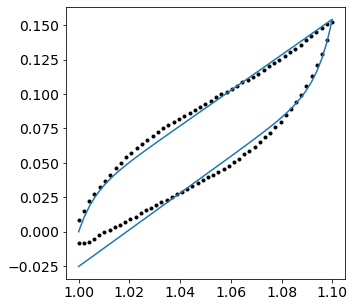

In [9]:
fig, ax = plt.subplots(figsize=[5,5])
sigm_pr,lm1,lm2,lm3,lm1e,lm2e,lm3e = uniaxial_cyclic(RG_params, RG_norm, False, t_load, t_unload, 1.1, dt0=0.5)

ax.plot(lm1,out[0],'k.')
ax.plot(lm1,sigm_pr[:,0,0])
# ax.set(title='t_peak = ' + str(np.round(t_peak)) + ', loss =' + str(np.round(train_loss[-1],5)))

# 2. Train $\Psi_{EQ}$ and $\Psi_{NEQ}$

In [10]:
with open('saved/brain_CR_RG_cclc_params.npy', 'rb') as f:
    RG_params = pickle.load(f)
RG_Psi_eq_params, RG_Psi_neq_params, RG_Phi_params = RG_params

In [11]:
# Generate training data
# Inputs
lm = np.linspace(0.85,1.1,20)
lm1, lm2 = np.array(np.meshgrid(lm, lm))
lm1 = lm1.reshape(-1)
lm2 = lm2.reshape(-1)
lm3 = 1/(lm1*lm2)
lmb_1 = np.transpose(np.array([lm1, lm2, lm3]))
lmb_2 = np.transpose(np.array([lm1, lm2, lm3*0.95]))
lmb = np.vstack([lmb_1, lmb_2])

# Outputs
sigma_gt = sigma_neoHook_vmap(lmb[:,0],lmb[:,1],lmb[:,2],RG_Psi_eq_params)

## 2.1 $\Psi_{EQ}$

In [12]:
# Initialize parameters
layers = [1, 5, 5, 1]
I1_params = init_params_nobias(layers, key)
I2_params = init_params_nobias(layers, key)
J1_params = init_params_nobias(layers, key)
alpha = 1.0
Psi1_bias = -3.0
Psi2_bias = -3.0
NN_weights = (I1_params, I2_params, J1_params)
K, mu = RG_Psi_eq_params
Psi_eq_params = (NN_weights, alpha, Psi1_bias, Psi2_bias, K)
Psi_eq_norm = None

# Train
opt_init, opt_update, get_params = optimizers.adam(1.e-4)
opt_state = opt_init(Psi_eq_params)
Psi_eq_params, train_loss, val_loss = train(lmb, sigma_gt, Psi_eq_norm, False, opt_state, key, Psi_loss, nIter = 200000, batch_size=10, print_freq=10000)
with open('saved/brain_CR_Psi_eq_cclc_params.npy', 'wb') as f:
    pickle.dump(Psi_eq_params, f)

it 0, train loss = 1.607513e+01
it 10000, train loss = 5.187603e-04
it 20000, train loss = 3.366190e-05
it 30000, train loss = 2.093338e-05
it 40000, train loss = 1.321121e-05
it 50000, train loss = 7.648598e-06
it 60000, train loss = 4.225200e-06
it 70000, train loss = 2.257376e-06
it 80000, train loss = 1.182325e-06
it 90000, train loss = 6.151107e-07
it 100000, train loss = 3.130907e-07
it 110000, train loss = 1.595750e-07
it 120000, train loss = 8.120103e-08
it 130000, train loss = 4.116607e-08
it 140000, train loss = 2.184080e-08
it 150000, train loss = 1.155609e-08
it 160000, train loss = 6.499041e-09
it 170000, train loss = 4.374482e-09
it 180000, train loss = 2.508125e-09
it 190000, train loss = 1.737233e-09
it 200000, train loss = 1.268287e-09


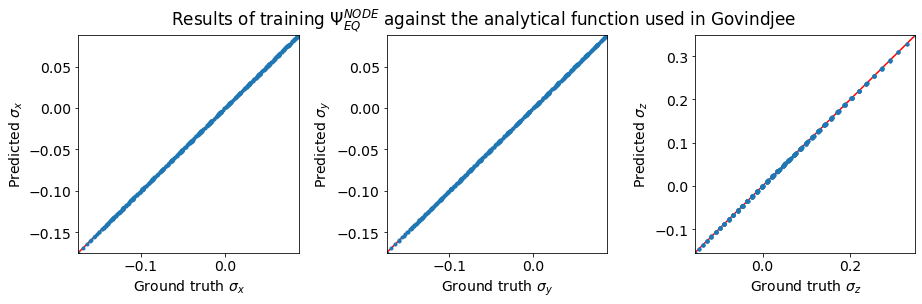

In [13]:
sigma_pr = sigma_split_vmap(lm1, lm2, lm3, Psi_eq_params)
sigma_gt = sigma_neoHook_vmap(lm1, lm2, lm3, RG_Psi_eq_params) #since I am using the same MM for both EQ and NEQ
gts = [sigma_gt[:,0,0], sigma_gt[:,1,1], sigma_gt[:,2,2]]
prs = [sigma_pr[:,0,0], sigma_pr[:,1,1], sigma_pr[:,2,2]]
labels = ['$\sigma_x$', '$\sigma_y$', '$\sigma_z$']
title = r"Results of training $\Psi_{EQ}^{NODE}$ against the analytical function used in Govindjee"
plot45(gts, prs, labels, title)

## 2.2 $\Psi_{NEQ}$

In [14]:
# Initialize parameters
I1_params = init_params_nobias(layers, key)
I2_params = init_params_nobias(layers, key)
J1_params = init_params_nobias(layers, key)
alpha = 1.0
Psi1_bias = -3.0
Psi2_bias = -3.0
NN_weights = (I1_params, I2_params, J1_params)
K, mu = RG_Psi_neq_params
Psi_neq_params = (NN_weights, alpha, Psi1_bias, Psi2_bias, K)
Psi_neq_norm = None

# Generate outputs
sigma_gt = sigma_neoHook_vmap(lmb[:,0],lmb[:,1],lmb[:,2],RG_Psi_neq_params)

opt_init, opt_update, get_params = optimizers.adam(1.e-4)
opt_state = opt_init(Psi_neq_params)
Psi_neq_params, train_loss, val_loss = train(lmb, sigma_gt, Psi_neq_norm, False, opt_state, key, Psi_loss, nIter = 200000, batch_size=10, print_freq=10000)

with open('saved/brain_CR_Psi_neq_cclc_params.npy', 'wb') as f:
    pickle.dump(Psi_neq_params, f)

it 0, train loss = 1.451060e+01
it 10000, train loss = 7.109666e-03
it 20000, train loss = 2.555276e-03
it 30000, train loss = 9.774531e-04
it 40000, train loss = 7.020835e-04
it 50000, train loss = 5.485372e-04
it 60000, train loss = 3.901496e-04
it 70000, train loss = 2.505562e-04
it 80000, train loss = 1.414708e-04
it 90000, train loss = 6.554245e-06
it 100000, train loss = 3.488976e-06
it 110000, train loss = 1.678505e-06
it 120000, train loss = 8.462930e-07
it 130000, train loss = 4.217692e-07
it 140000, train loss = 2.740208e-07
it 150000, train loss = 1.081895e-07
it 160000, train loss = 5.559676e-08
it 170000, train loss = 3.649776e-07
it 180000, train loss = 1.598547e-08
it 190000, train loss = 9.272679e-09
it 200000, train loss = 5.457691e-09


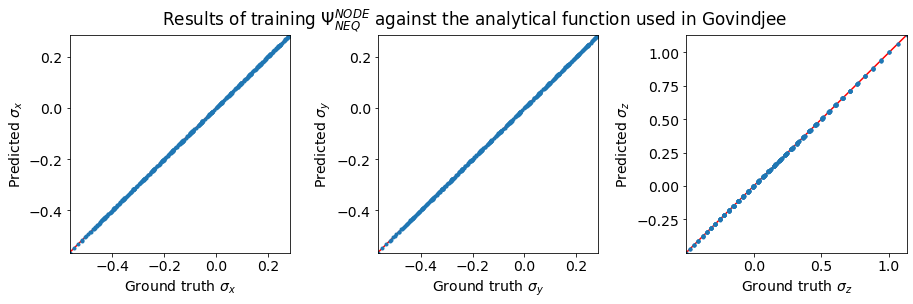

In [15]:
sigma_pr = sigma_split_vmap(lm1, lm2, lm3, Psi_neq_params)
sigma_gt = sigma_neoHook_vmap(lm1, lm2, lm3, RG_Psi_neq_params)
gts = [sigma_gt[:,0,0], sigma_gt[:,1,1], sigma_gt[:,2,2]]
prs = [sigma_pr[:,0,0], sigma_pr[:,1,1], sigma_pr[:,2,2]]
labels = ['$\sigma_x$', '$\sigma_y$', '$\sigma_z$']
title = r"Results of training $\Psi_{NEQ}^{NODE}$ against the analytical function used in Govindjee"
plot45(gts, prs, labels, title)

# 3. Train $\Phi^{NODE}$ with $\Phi^{Govindjee}$

In [16]:
with open('saved/brain_CR_RG_cclc_params.npy', 'rb') as f:
    RG_params = pickle.load(f)
RG_Psi_eq_params, RG_Psi_neq_params, RG_Phi_params = RG_params
eta_D, eta_V = RG_Phi_params

In [17]:
# Generate training data
# Input data and normalization factors
taui = onp.mgrid[-1.0:1.0:10j, -1.0:1.0:10j, -1.0:1.0:10j]
taui = taui.reshape([3,-1]).transpose()
taui = -onp.sort(-taui)

tau1 = taui[:,0]
tau2 = taui[:,1]
tau3 = taui[:,2]
I12     = tau1**2 + tau2**2 + tau3**2 + 2*tau1*tau2 + 2*tau1*tau3 + 2*tau2*tau3
I12m3I2 = tau1**2 + tau2**2 + tau3**2 -   tau1*tau2 -   tau1*tau3 -   tau2*tau3

inp_std3 = onp.std(tau1 + tau2 + tau3)
inp_std4 = onp.std(I12)
inp_std5 = onp.std(I12m3I2)
inp_stds = (inp_std3, inp_std4, inp_std5)

out_std3 = 1.0
out_std4 = 1/9/175000
out_std5 = 1/3/1360
out_stds = (out_std3, out_std4, out_std5)
Phi_norm = (inp_stds, out_stds)

# Output data
dphidtaui = onp.array(dPhi_RG_vmap([taui[:,0], taui[:,1], taui[:,2]], eta_D, eta_V)).transpose()

# Initialize NN weights
layers = [1,2,3,1]
NODE3_params = init_params_positivebias(layers, key)
NODE4_params = init_params_positivebias(layers, key)
NODE5_params = init_params_positivebias(layers, key)
Phi_params = [NODE3_params, NODE4_params, NODE5_params]

In [18]:
opt_init, opt_update, get_params = optimizers.adam(1.e-4)
opt_state = opt_init(Phi_params)
Phi_params, train_loss, val_loss = train(taui, dphidtaui, Phi_norm, False, opt_state, key, Phi_loss, nIter = 200000, batch_size=100, print_freq=10000)

with open('saved/brain_CR_Phi_cclc_params.npy', 'wb') as f:
    pickle.dump(Phi_params, f)
with open('saved/brain_CR_Phi_cclc_norm_w.npy', 'wb') as f:
    pickle.dump(Phi_norm, f)

it 0, train loss = 7.932837e+00
it 10000, train loss = 5.517194e-01
it 20000, train loss = 4.863526e-01
it 30000, train loss = 4.657889e-01
it 40000, train loss = 4.163873e-01
it 50000, train loss = 2.913522e-01
it 60000, train loss = 6.455325e-02
it 70000, train loss = 1.362806e-05
it 80000, train loss = 1.293015e-05
it 90000, train loss = 1.105258e-05
it 100000, train loss = 6.534875e-06
it 110000, train loss = 7.078007e-07
it 120000, train loss = 4.318830e-07
it 130000, train loss = 4.320368e-07
it 140000, train loss = 4.338307e-07
it 150000, train loss = 4.342291e-07
it 160000, train loss = 4.318326e-07
it 170000, train loss = 4.315759e-07
it 180000, train loss = 4.315361e-07
it 190000, train loss = 4.318006e-07
it 200000, train loss = 4.328765e-07


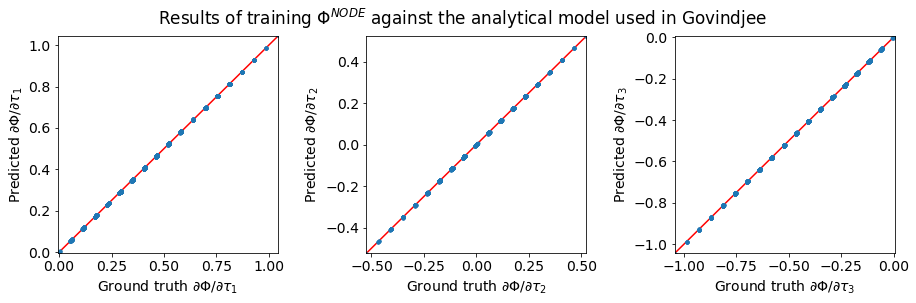

In [19]:
prs = dPhi_vmap([taui[:,0], taui[:,1], taui[:,2]], Phi_params, Phi_norm)
gts = dPhi_RG_vmap([taui[:,0], taui[:,1], taui[:,2]], eta_D, eta_V)

labels = ['$\partial \Phi / \partial \\tau_1$', '$\partial \Phi / \partial \\tau_2$', '$\partial \Phi / \partial \\tau_3$']
title = r"Results of training $\Phi^{NODE}$ against the analytical model used in Govindjee"
plot45(gts, prs, labels, title)

# 4. Test
You need to run the cell at the beginning where inp and out are defined to be able to use the following

In [20]:
#Load the pre-trained parameters
with open('saved/brain_CR_Psi_eq_cclc_params.npy', 'rb') as f:
    Psi_eq_params = pickle.load(f)
with open('saved/brain_CR_Psi_neq_cclc_params.npy', 'rb') as f:
    Psi_neq_params = pickle.load(f)
with open('saved/brain_CR_Phi_cclc_params.npy', 'rb') as f:
    Phi_params = pickle.load(f)
with open('saved/brain_CR_Phi_cclc_norm_w.npy', 'rb') as f:
    Phi_norm = pickle.load(f)
params = (Psi_eq_params, Psi_neq_params, Phi_params)
norm = (None, None, Phi_norm)

with open('saved/brain_CR_RG_cclc_params.npy', 'rb') as f:
    RG_params = pickle.load(f)

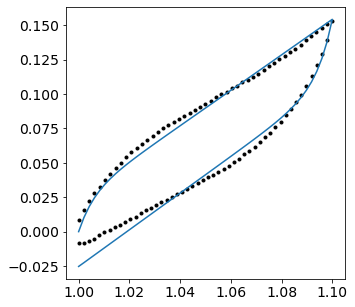

In [21]:
fig, ax = plt.subplots(figsize=[5,5])
sigm_pr,lm1,lm2,lm3,lm1e,lm2e,lm3e = uniaxial_cyclic(params, norm, True, t_load, t_unload, 1.1, dt0=0.5)

ax.plot(lm1,out[0],'k.')
ax.plot(lm1,sigm_pr[:,0,0])

## 5. Retrain

2023-03-28 20:09:14.425173: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:55] 
********************************
Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
Compiling module jit_step.210
********************************
2023-03-28 21:26:04.918418: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:55] 
********************************
Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
Compiling module jit_uniaxial_cyclic.211
********************************


it 0, train loss = 2.928623e-05
it 100, train loss = 2.924724e-05
it 200, train loss = 2.921965e-05
it 300, train loss = 2.919518e-05
it 400, train loss = 2.917231e-05
it 500, train loss = 2.915041e-05
it 600, train loss = 2.912873e-05
it 700, train loss = 2.910658e-05
it 800, train loss = 2.908420e-05
it 900, train loss = 2.906145e-05
it 1000, train loss = 2.903812e-05
it 1100, train loss = 2.901388e-05
it 1200, train loss = 2.898902e-05
it 1300, train loss = 2.896337e-05
it 1400, train loss = 2.893682e-05
it 1500, train loss = 2.890937e-05
it 1600, train loss = 2.888094e-05
it 1700, train loss = 2.885128e-05
it 1800, train loss = 2.882050e-05
it 1900, train loss = 2.878851e-05
it 2000, train loss = 2.875510e-05
it 2100, train loss = 2.872015e-05
it 2200, train loss = 2.868368e-05
it 2300, train loss = 2.864543e-05
it 2400, train loss = 2.860496e-05
it 2500, train loss = 2.856238e-05
it 2600, train loss = 2.851758e-05
it 2700, train loss = 2.847012e-05
it 2800, train loss = 2.841947e-

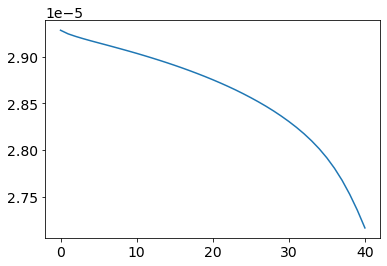

In [22]:
opt_init, opt_update, get_params = optimizers.adam(1.e-4)
opt_state = opt_init(params)

params, train_loss, val_loss = train(inp, out, norm, True, opt_state, key, uniaxial_cyclic_batch_loss, nIter = 4000, batch_size=1, print_freq=100)

with open('saved/brain_CR_cclc_params_retrained.npy', 'wb') as f:
    pickle.dump(params, f)

plt.plot(train_loss)
# Current best loss: 3.441843e-04 with nIter=3000, lr = 1.e-4

## 6. Final test

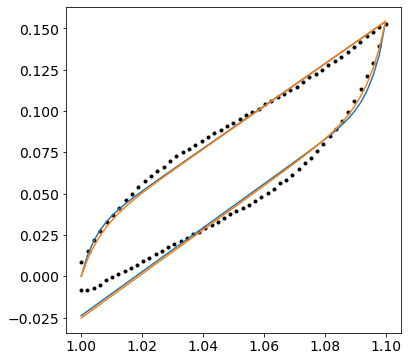

In [23]:
with open('saved/brain_CR_cclc_params_retrained.npy', 'rb') as f:
    params = pickle.load(f)
with open('saved/brain_CR_Phi_cclc_norm_w.npy', 'rb') as f:
    Phi_norm = pickle.load(f)

with open('saved/brain_CR_RG_cclc_params.npy', 'rb') as f:
    RG_params = pickle.load(f)
norm = (None, None, Phi_norm)
lm0 = 0.9

fig, ax = plt.subplots(figsize=(6,6))

sig_NN, lm1_NN, lm2_NN, lm3_NN, lm1e_NN, lm2e_NN, lm3e_NN  = uniaxial_cyclic(params, norm, True, t_load, t_unload, 1.1, dt0=0.5)
sig_RG, lm1_NN, lm2_NN, lm3_NN, lm1e_NN, lm2e_NN, lm3e_NN  = uniaxial_cyclic(RG_params, norm, False, t_load, t_unload, 1.1, dt0=0.5)

ax.plot(lm1_NN,out[0],'k.')
ax.plot(lm1_NN,sig_NN[:,0,0])
ax.plot(lm1_NN,sig_RG[:,0,0])


data = np.array([lm1_NN, out[0], sig_NN[:,0,0], sig_RG[:,0,0]])
columns = ['x', 'y_gt', 'y_nn', 'y_rg']
df = pd.DataFrame(data.T, columns=columns)
df.to_csv('tikz_data/fig_brain_cclc/fig_brain_CR.csv', index=False, sep=' ')

In [24]:
print('MAE of RG and NN:')
print(np.mean(np.abs(out[0]-sig_RG[:,0,0])), np.mean(np.abs(out[0]-sig_NN[:,0,0])))

MAE of RG and NN:
0.004323116009410938 0.00419914353251069


In [25]:
print('MRE of RG and NN:')
aux1 = (out[0]-sig_RG[:,0,0])/out[0]
aux2 = (out[0]-sig_NN[:,0,0])/out[0]
print(np.mean(np.abs(aux1[1:])), np.mean(np.abs(aux2[1:])))

MRE of RG and NN:
0.5743628226668882 0.5030055506587491
